In [1]:
import numpy as np
rd_st = np.random.RandomState(42)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
from multiprocessing import Pool

import time
import ipdb
from IPython import display

%matplotlib inline

In [2]:
from rider import *

# Load data, Hong Kong road network

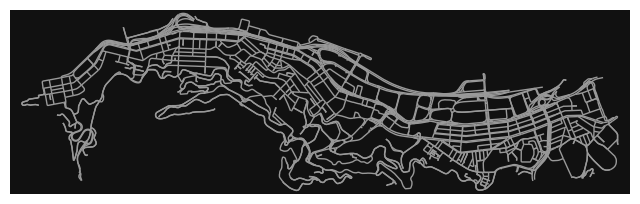

In [3]:
fig, ax = ox.plot_graph(G_osm, node_size=0)

In [4]:
# defined in rider.py
nodes.head()

NodeName         x         y
0   24533064  5.301182  0.410478
1  165996965  3.915847  1.019657
2  165997625  4.219332  0.809467
3  165997863  4.540377  0.585858
4  165997979  4.611950  0.579487

In [5]:
# defined in rider.py
edges.head()

EdgeName       from          to  distance
0         0   24533064  1618530627  0.038526
1         1   24533064   297187423  0.030191
2         2  165996965   366080458  0.166833
3         3  165997625  4502672959  0.054389
4         4  165997625   166091633  0.060781

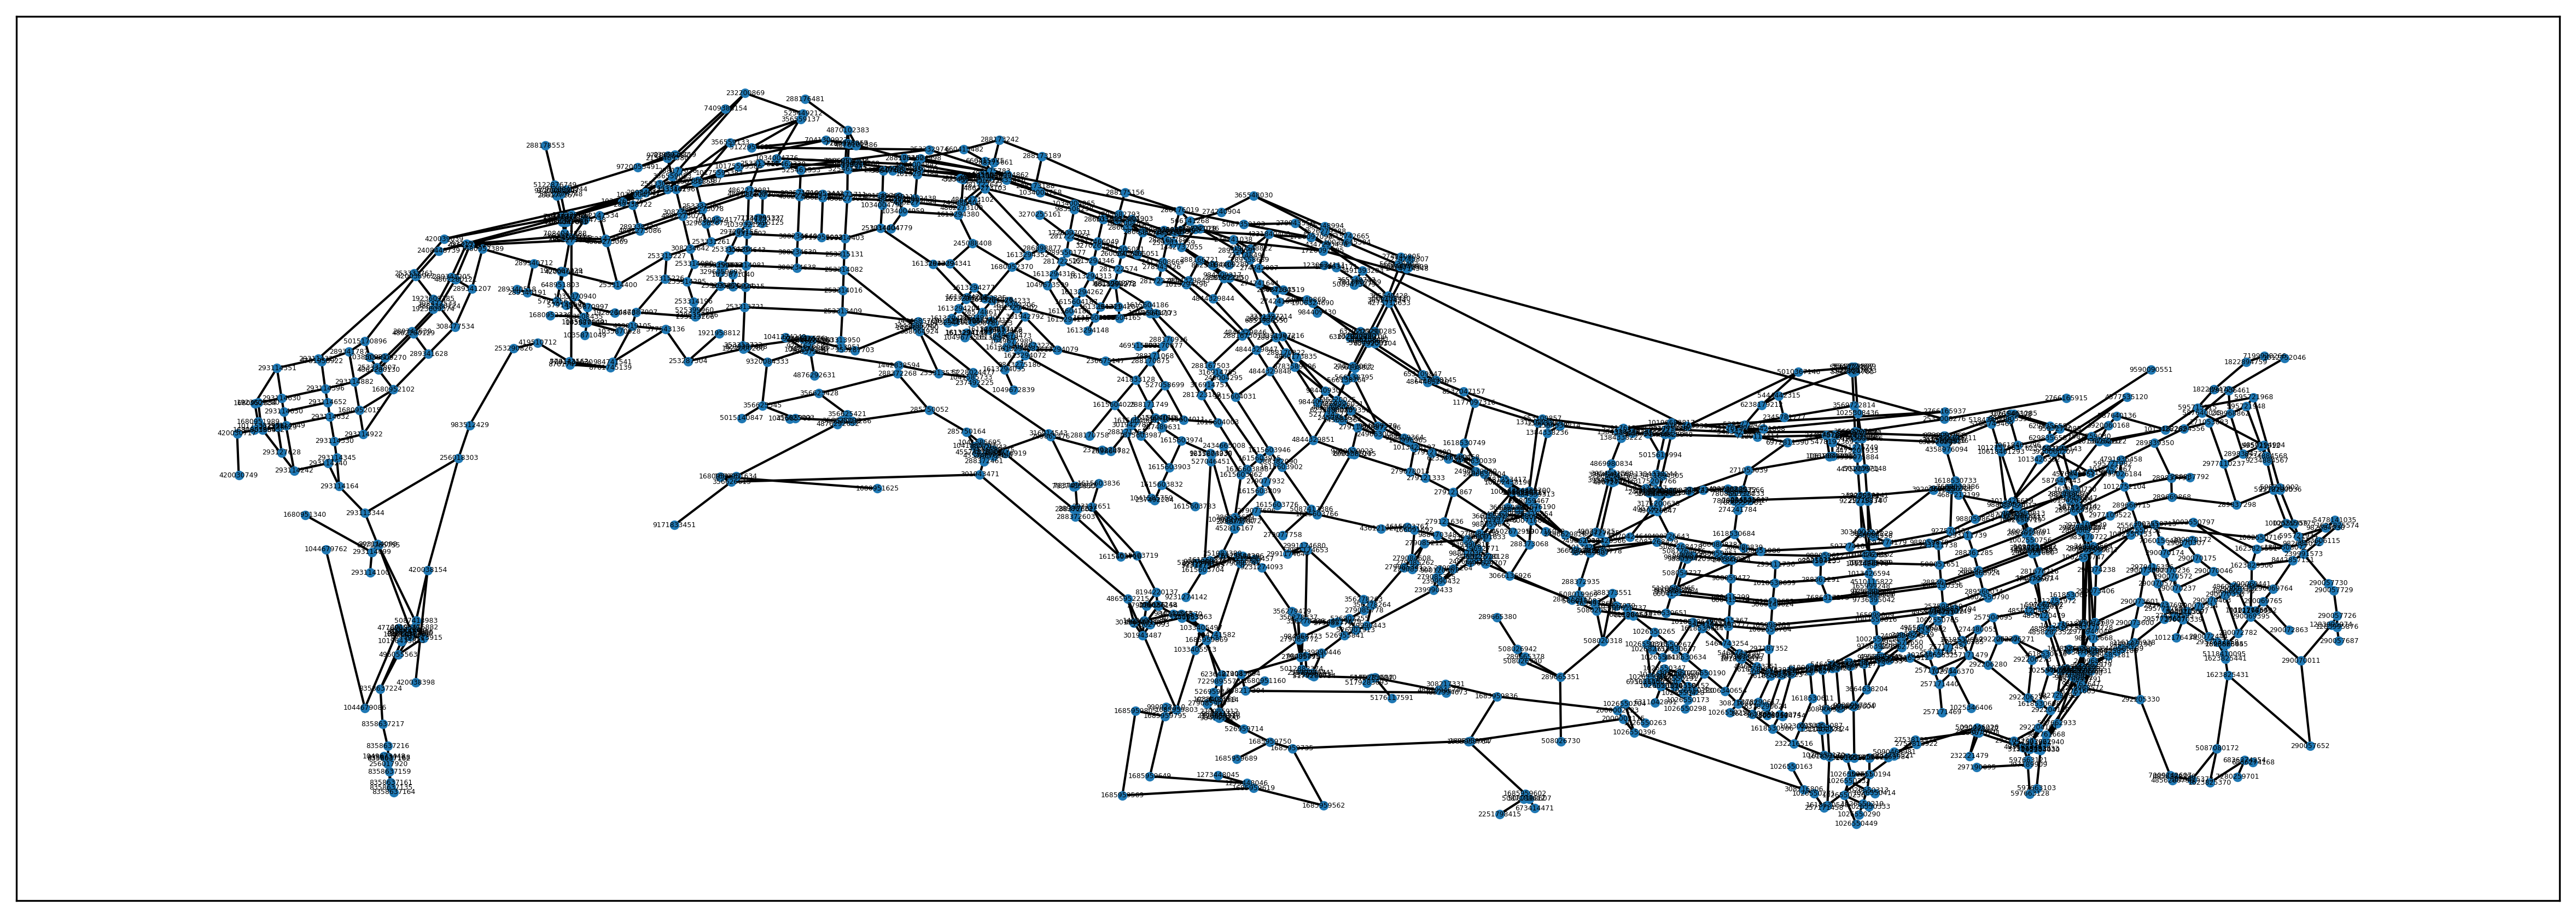

In [6]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

plt.figure(figsize=[20,7], dpi=300)
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos, font_size=3, node_size=10)

Try Dijkstra method

In [7]:
nx.dijkstra_path(G, 288361285, 3066136926)

[288361285,
 508051651.0,
 288361295.0,
 9736395052.0,
 9736395051.0,
 7686317275.0,
 1618530653.0,
 660415299.0,
 5118507964.0,
 660415375.0,
 660415370.0,
 1618530651.0,
 508018737.0,
 165997979.0,
 165997863.0,
 508019983.0,
 288372937.0,
 3066136926.0]

# Define rider

In [8]:
# in rider.py

# Define platform


In [9]:
class platform:
    def __init__(self, r, cR, k, t):
        self.customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )

        self.matched_customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )
        
        self.num_accumulated_order = 0
        self.r = r
        self.cR = cR
        self.k = k
        self.t = t
    
    def update_cust_df_with_new_cust(self, n=1):
        c = 0
        while True and n > 0:
            ind = self.customer_df.shape[0]
            node_ID = rd_st.choice(list(nodes['NodeName']))
            node_position = get_node_xy(node_ID)
            merchant_node = rd_st.choice(merchant_node_set)
            
            if np.linalg.norm(node_position - get_node_xy(merchant_node)) < cR:
                new_customer = pd.DataFrame(
                    [[node_ID, merchant_node, 0, node_position[0], node_position[1]]],
                    index=[ind],
                    columns=['node_ID', 'merchant_node', 'waiting_time', 'position_x', 'position_y']
                )
                self.customer_df = pd.concat([self.customer_df, new_customer], axis=0, ignore_index=True)
                c = c + 1
                
            if c == n:
                break
    
    def acquire_order(self, q):
        # num_generated_order_c is continuous ('_c'), not discrete
        num_generated_order_c = rd_st.rand() * q * t_resolution * 2
        self.num_accumulated_order += num_generated_order_c
        num_generated_order = int(self.num_accumulated_order - self.customer_df.shape[0])
        
        self.update_cust_df_with_new_cust(num_generated_order)
        
        self.customer_df['waiting_time'] = self.customer_df['waiting_time'] + t_resolution
        self.matched_customer_df['waiting_time'] = self.matched_customer_df['waiting_time'] + t_resolution
        
    
    def update_matched_order(self, matched_batches):
        for i in matched_batches.flatten():
            first_cust_ind = self.customer_df.loc[self.customer_df['node_ID']==i, 'waiting_time'].astype(float).idxmax()
            self.matched_customer_df = self.matched_customer_df.append(self.customer_df.loc[first_cust_ind])
            self.customer_df = self.customer_df.drop(index=first_cust_ind)
        
        self.matched_customer_df.index = range(self.matched_customer_df.shape[0])
        self.customer_df.index = range(self.customer_df.shape[0])
        
        self.num_accumulated_order -= matched_batches.size
    
    def match(self, idle_rider_IDs, rider_set):
        # when multiprocessing, the rider ID and index of each rider
        # in the rider_set list are not necessarily the same
        rider_ID_set = [i.ID for i in rider_set]
        rider_index_df = pd.DataFrame(range(len(rider_ID_set)), index=rider_ID_set, columns=['ind'])
        
        matched_batches = []
        matched_rider_IDs = []
        matched_merchants = []
        
        for i in range(len(merchant_node_set)):
            # first find corresponding idle rider IDs
            merchant_node = merchant_node_set[i]
            idle_rider_IDs_this_merchant = []
            for idle_rider_ID in idle_rider_IDs:
                idle_rider = rider_set[rider_index_df.loc[idle_rider_ID, 'ind']]
                if idle_rider.closest_merchant_node==merchant_node:
                    idle_rider_IDs_this_merchant.append(idle_rider_ID)
            n_idle_riders_this_merchant = len(idle_rider_IDs_this_merchant)
            
            # accumulatd orders for this merchant
            acc_ord_this_mer_df = self.customer_df.loc[self.customer_df['merchant_node']==merchant_node]
            acc_ord_this_mer = acc_ord_this_mer_df['node_ID'].astype(int).values
            
            num_required_riders_this_merchant = min(
                n_idle_riders_this_merchant,
                # number of accumulated orders for this merchant // k
                len(acc_ord_this_mer) // self.k
            )
            
            matched_rider_IDs_this_merchant = list(rd_st.choice(
                idle_rider_IDs_this_merchant,
                num_required_riders_this_merchant,
                replace=False
            ))
            
            matched_batches_this_merchant = []
            for j in range(len(matched_rider_IDs_this_merchant)):
                matched_batches_this_merchant.append(acc_ord_this_mer[self.k*j:self.k*(j+1)])
                matched_merchants.append(merchant_node)
            matched_batches_this_merchant = np.array(matched_batches_this_merchant)
            
            matched_batches.extend(matched_batches_this_merchant)
            matched_rider_IDs.extend(matched_rider_IDs_this_merchant)
        
        matched_batches = np.array(matched_batches)
        # remove the matched orders
        self.update_matched_order(matched_batches)
        W_cq_4_matched_customers = []
        for i in np.array(matched_batches).flatten():
            W_cq_4_matched_customers.append(self.customer_df['waiting_time'])
        avg_W_cq = np.mean(W_cq_4_matched_customers) if len(W_cq_4_matched_customers)>0 else np.nan
        
        # their indexes are mutually matched
        return matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq  
        

In [10]:
# Multi processing, but it is slower if only step one pace forward
def move_all_riders():
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = N//N_each_process+1 if N%N_each_process != 0 else N//N_each_process

    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches,
                matched_merchants,
                dec_var
            ]
        )
    
    moved_rider_set = pool.starmap(func=move_rider, iterable=params )
    return moved_rider_set


In [11]:
config_set = []
rider_set = []
N = 200
q_bar = 800
r = 1
cR = 2
k = 3
t = 0.005

Delta = cR
t_resolution = 0.001
match_period = t//t_resolution if t%t_resolution==0 else t//t_resolution+1

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t,
    'N': N,
    'q_bar': q_bar
}

merchant_node_set = [5015140847, 1680952102, 4844329848, 288361285, 3066136926]

In [12]:
num_new_riders = N


num_exist_riders = len(rider_set)
new_rider_count = 0
while new_rider_count < num_new_riders:
    config_i = {
        'ID': num_exist_riders + new_rider_count,
        'initial_position': np.array([rd_st.rand()*nodes['x'].max(), rd_st.rand()*nodes['y'].max()]),
        'maxspeed': rd_st.randint(10, 20)
    }
    rider_i = rider(config_i, dec_var, merchant_node_set, rd_st)
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    
    new_rider_count += 1

In [13]:
virtual_plat = platform(r, cR, k, t)

In [14]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []
avg_W_cq_set = []

In [15]:
n_cpu = multiprocessing.cpu_count()
pool = Pool(processes=n_cpu)

rider 117 completed! time:0.44
rider 58 completed! time:0.48
rider 15 completed! time:0.57
rider 48 completed! time:0.51
rider 153 completed! time:0.56
rider 139 completed! time:0.44
rider 145 completed! time:0.53
rider 173 completed! time:0.53
rider 78 completed! time:0.63
rider 17 completed! time:0.51
rider 73 completed! time:0.62
rider 118 completed! time:0.64
rider 149 completed! time:0.51
rider 194 completed! time:0.58
rider 168 completed! time:0.62
rider 181 completed! time:0.49
rider 155 completed! time:0.64
rider 124 completed! time:0.60
rider 93 completed! time:0.57
rider 95 completed! time:0.64
rider 21 completed! time:0.67
rider 199 completed! time:0.54
rider 127 completed! time:0.42
rider 80 completed! time:0.60
rider 140 completed! time:0.62
rider 12 completed! time:0.65
rider 97 completed! time:0.54
rider 37 completed! time:0.64
rider 94 completed! time:0.61
rider 179 completed! time:0.38
rider 75 completed! time:0.76
rider 71 completed! time:0.78
rider 76 completed! time

rider 151 completed! time:0.91
rider 13 completed! time:0.66
rider 98 completed! time:0.90
rider 19 completed! time:0.78
rider 162 completed! time:1.23
rider 194 completed! time:0.61
rider 182 completed! time:0.92
rider 115 completed! time:0.68
rider 130 completed! time:0.50
rider 158 completed! time:0.67
rider 10 completed! time:0.48
rider 59 completed! time:0.93
rider 23 completed! time:0.52
rider 174 completed! time:0.51
rider 7 completed! time:0.53
rider 83 completed! time:0.72
rider 192 completed! time:0.79
rider 11 completed! time:1.00
rider 189 completed! time:0.63

rider 139 completed! time:0.71rider 163 completed! time:0.87
rider 155 completed! time:0.62
rider 2 completed! time:0.55
rider 90 completed! time:0.58
rider 27 completed! time:0.71
rider 66 completed! time:0.61
rider 160 completed! time:0.85
rider 92 completed! time:0.63
rider 95 completed! time:0.45
rider 9 completed! time:0.75
rider 188 completed! time:0.66
rider 97 completed! time:0.72
rider 125 completed! time:0.

rider 55 completed! time:0.77
rider 13 completed! time:1.09
rider 147 completed! time:0.57
rider 190 completed! time:0.61
rider 8 completed! time:0.68
rider 67 completed! time:0.57
rider 106 completed! time:0.74
rider 16 completed! time:0.64
rider 175 completed! time:0.78
rider 89 completed! time:0.94
rider 130 completed! time:1.10
rider 22 completed! time:0.75
rider 72 completed! time:0.53
rider 163 completed! time:1.08
rider 152 completed! time:0.76
rider 90 completed! time:0.57
rider 136 completed! time:0.65
rider 111 completed! time:0.94
rider 139 completed! time:0.59
rider 48 completed! time:0.49
rider 63 completed! time:0.70
rider 170 completed! time:0.67
rider 76 completed! time:0.69
rider 1 completed! time:0.70
rider 29 completed! time:0.76
rider 35 completed! time:0.93
rider 114 completed! time:0.79
rider 50 completed! time:0.79
rider 198 completed! time:0.94
rider 7 completed! time:0.52
rider 131 completed! time:0.79
rider 0 completed! time:0.50
rider 153 completed! time:0.67

rider 85 completed! time:0.53
rider 177 completed! time:0.63
rider 30 completed! time:1.06
rider 169 completed! time:0.88
rider 42 completed! time:0.48
rider 53 completed! time:0.61
rider 80 completed! time:0.89
rider 71 completed! time:0.59
rider 182 completed! time:0.60
rider 171 completed! time:0.65
rider 125 completed! time:0.62
rider 67 completed! time:0.82
rider 36 completed! time:0.59
rider 47 completed! time:0.77
rider 191 completed! time:0.61
rider 119 completed! time:0.51
rider 106 completed! time:0.91
rider 11 completed! time:0.66
rider 66 completed! time:0.72
rider 70 completed! time:0.67
rider 25 completed! time:0.46
rider 14 completed! time:0.53
rider 28 completed! time:0.59
rider 18 completed! time:0.69
rider 63 completed! time:0.78
rider 166 completed! time:0.91
rider 195 completed! time:0.58
rider 161 completed! time:0.65
rider 138 completed! time:0.66
rider 149 completed! time:0.47
rider 158 completed! time:0.66
rider 184 completed! time:0.86
rider 116 completed! time

rider 58 completed! time:0.62
rider 194 completed! time:0.74
rider 26 completed! time:0.73


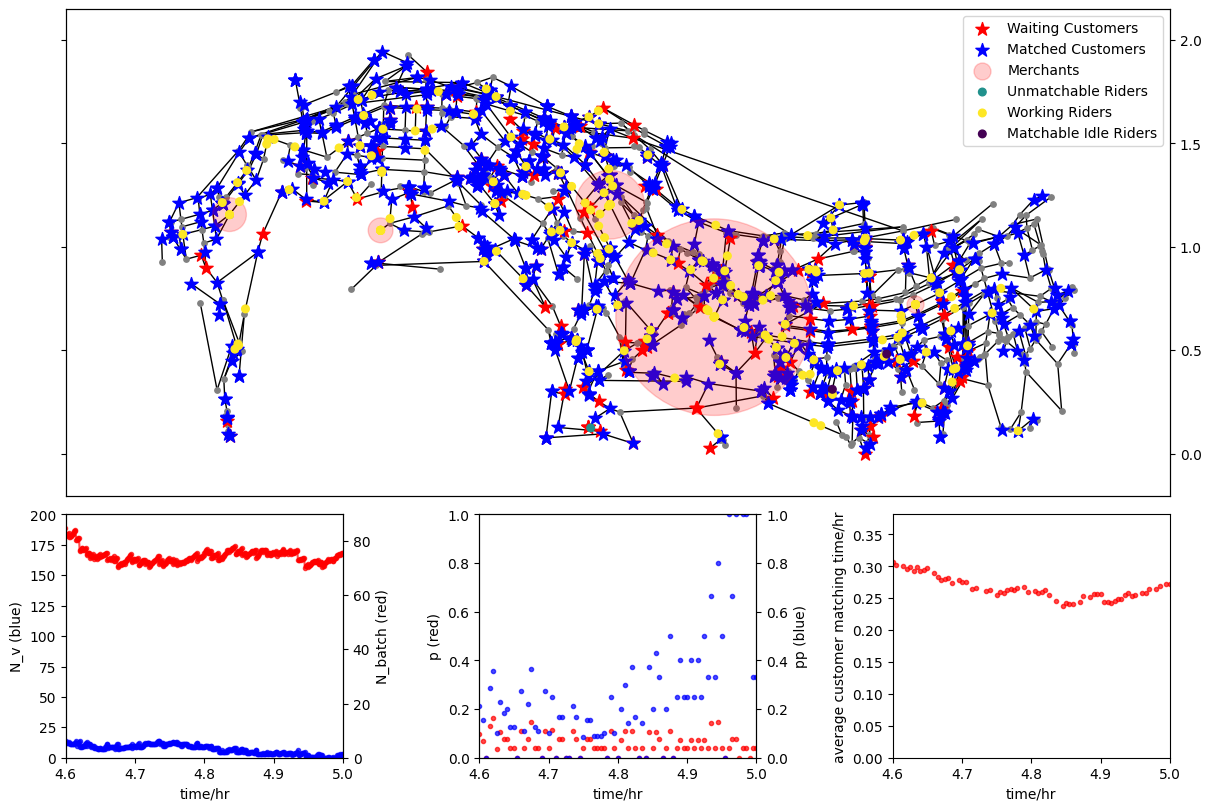

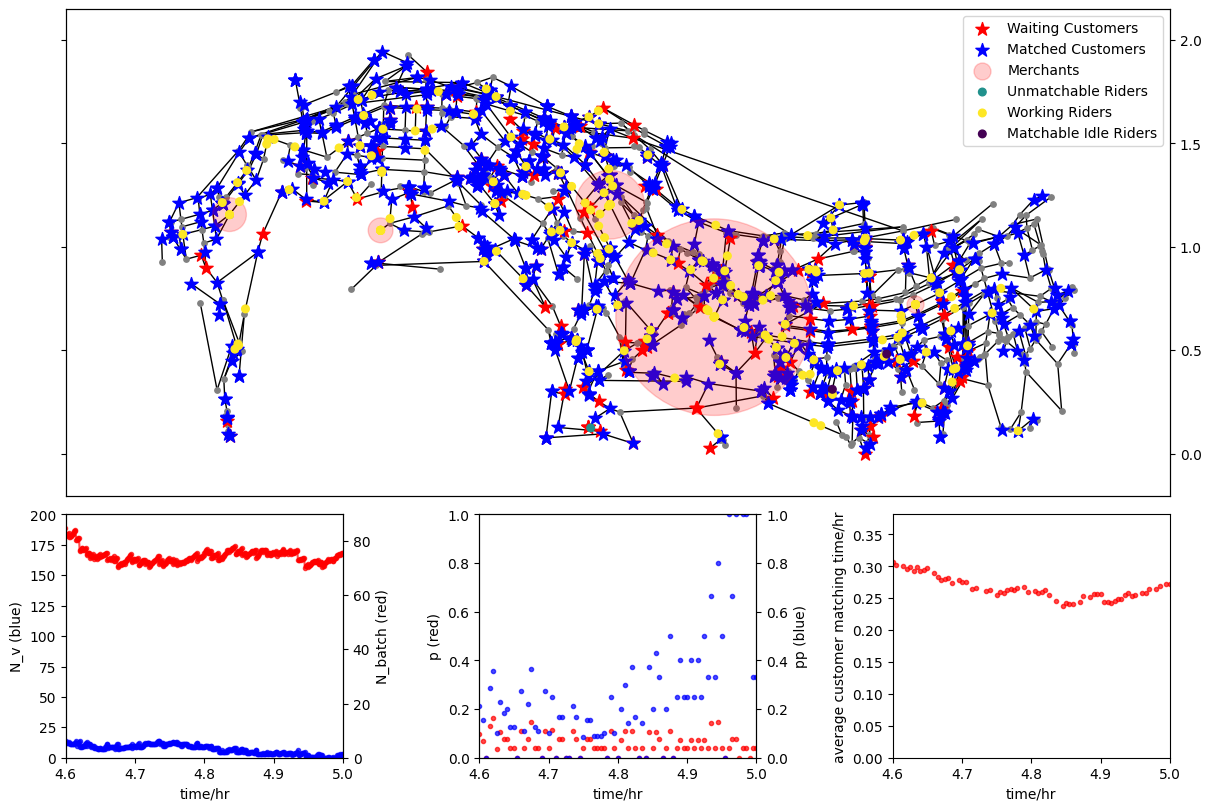

In [16]:
# marking the x-axis and y-axis
fig = plt.figure(constrained_layout=True, figsize=[12, 8])
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[:2, :3])
nx.draw_networkx(G, pos=pos, ax=ax0, node_size=15, node_color='gray', with_labels=False)
ax = ax0.twinx()
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())

ax2 = fig.add_subplot(gs[2, 0])
ax2.set_ylabel('N_v (blue)')
ax2.set_xlabel('time/hr')
ax3 = ax2.twinx()
ax3.set_ylabel('N_batch (red)')
ax3.set_xlabel('time/hr')
ax4 = fig.add_subplot(gs[2, 1])
ax4.set_ylabel('p (red)')
ax4.set_xlabel('time/hr')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_xlabel('time/hr')
ax5.set_ylim([0, 1])
ax6 = fig.add_subplot(gs[2, 2])
ax6.set_ylabel('average customer matching time/hr')
ax6.set_xlabel('time/hr')

# plt.tight_layout()


scat2 = ax.scatter([], [], color='red', marker='*', s=100, label='Waiting Customers')  # for waiting customers
scat3 = ax.scatter([], [], color='blue', marker='*', s=100, label='Matched Customers')  # for matched customers
scat4 = ax.scatter([], [], color='red', alpha=0.2, label='Merchants', s=150)  # for merchants

# riders
color = np.ones(N) * 0.5
scat = ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N) * 0.5, vmin=0, vmax=1, label='Unmatchable Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N), vmin=0, vmax=1, label='Working Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.zeros(N), vmin=0, vmax=1, label='Matchable Idle Riders')
ax.legend(loc='upper right')

line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)
line6, = ax6.plot([], [], 'r.-', alpha=0.7)

while c <= 5000:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)
    
    q = q_bar * cR**2 / Delta**2
    virtual_plat.acquire_order(q)
    
    if int(c%match_period)==0:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = virtual_plat.match(
            idle_rider_IDs, rider_set
        )
    else:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = np.array([]), [], [], np.nan
    
    num_matched_cust = matched_batches.size if int(c%match_period)==0 else np.nan
    try:
        p = num_matched_cust / (num_matched_cust + virtual_plat.num_accumulated_order/k)
    except:
        # when there is no order
        p = np.nan
    num_matched_rider_IDs = num_matched_cust // k
    try:
        pp = num_matched_rider_IDs / len(idle_rider_IDs)
    except:
        pp = np.nan

    # move
#     rider_set = move_rider(
#         rider_set, t_resolution, matched_rider_IDs, matched_batches, matched_merchants, dec_var
#     )
    # for multiprocessing, uncomment the following lines
    moved_rider_set = move_all_riders()
    moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
    rider_set = moved_rider_set
    
    # update delivered customers
    delivered_customers_set = []
    for each_rider in rider_set:
        delivered_customers_set.append(each_rider.newly_finished_destination)
        
    for delivered_customer in delivered_customers_set:
        if delivered_customer in list(virtual_plat.matched_customer_df['node_ID']):
            virtual_plat.matched_customer_df = virtual_plat.matched_customer_df.drop(
                virtual_plat.matched_customer_df.loc[
                    virtual_plat.matched_customer_df['node_ID']==delivered_customer, 'waiting_time'
                ].astype(float).idxmax()
            )
    virtual_plat.matched_customer_df.index = range(virtual_plat.matched_customer_df.shape[0])
    
    time_now = c * t_resolution
    x_axis.append(time_now)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(virtual_plat.num_accumulated_order/k)  # continuous
    p_set.append(p)
    pp_set.append(pp)
    avg_W_cq_set.append(avg_W_cq)
    
    if c>=1 and c%2==0:
        # plot customers
        if virtual_plat.customer_df.shape[0]>0:
            cust_pos = np.array(virtual_plat.customer_df[['position_x', 'position_y']].to_numpy())
            scat2.set_offsets(cust_pos)
        if virtual_plat.matched_customer_df.shape[0] > 0:
            cust_pos_m = np.array(virtual_plat.matched_customer_df[['position_x', 'position_y']].to_numpy())
            scat3.set_offsets(cust_pos_m)
        
        # plot riders
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )
        
        # plot merchants
        merchant_pos = [[get_node_xy(i)[0], get_node_xy(i)[1]] for i in merchant_node_set]
        scat4.set_offsets(np.array(merchant_pos))
        acc_orders_by_merchant = []
        for i in merchant_node_set:
            acc_orders_by_merchant.append(virtual_plat.customer_df.loc[virtual_plat.customer_df['merchant_node']==i].shape[0])
        scat4.set_sizes(150 + np.array(acc_orders_by_merchant)**2)
        
        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        line5.set_data(x_axis, pp_set)
        line6.set_data(x_axis, avg_W_cq_set)

        ax2.set_xlim([max(0, time_now - 0.4), time_now])
        ax3.set_xlim([max(0, time_now - 0.4), time_now])
        ax4.set_xlim([max(0, time_now - 0.4), time_now])
        ax5.set_xlim([max(0, time_now - 0.4), time_now])
        ax6.set_xlim([max(0, time_now - 0.4), time_now])
        if np.isnan(np.nanmax(avg_W_cq_set))==False:
            ax6.set_ylim([0, 1.2 * np.nanmax(avg_W_cq_set)])

        display.clear_output(wait=True)
        display.display(plt.gcf())
    
        fig.savefig('./res_img/%i%.4f.png'%(time_now//10, time_now-time_now//10*10 ), dpi=75)
    c += 1
    

In [17]:
# # make gif
# import glob
# from PIL import Image
# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
#     frame_one = frames[0]
#     frame_one.save('./res_img/demo0.gif', format="GIF", append_images=frames,
#                save_all=True, duration=35, loop=0)
    

# make_gif("./res_img/")

In [20]:
import cv2
import numpy as np
import glob

img_array = []
for filename in sorted(glob.glob("res_img/*.png")):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('./res_img/project.mp4',cv2.VideoWriter_fourcc('m', 'p', '4', 'v') , 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

import os
for i in sorted(glob.glob("res_img/*.png")):
    os.remove(i)